In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
import cv2

2024-03-06 05:28:00.785576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 05:28:00.785668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 05:28:00.787273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 05:28:00.798854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 05:28:01.579145: W tensorflow/compiler/tf2

In [3]:
!pwd

/mnt/e/ResearchProjects/malaraiaclassification/research


In [4]:
cd ..

/mnt/e/ResearchProjects/malaraiaclassification


In [5]:
# dataset, dataset_info = tfds.load('malaria', with_info= True, as_supervised =True, shuffle_files = True, split= ['train'])
img_dir="dataset"
img_size=64

In [6]:
def load_img_data(path):
    image_files = glob.glob(os.path.join(path, "Parasitized/*.png")) + \
                  glob.glob(os.path.join(path, "Uninfected/*.png"))
    X, y = [], []
    for image_file in image_files:
        # 0 for uninfected and 1 for infected
        label = 0 if "Uninfected" in image_file else 1
        # load the image in gray scale
        img_arr = cv2.imread(image_file)
        # resize the image to (70x70)
        img_resized = cv2.resize(img_arr, (img_size, img_size))/255.0
        X.append(img_resized)
        y.append(label)
    return X, y

In [7]:
X, y = load_img_data(img_dir)

In [8]:
len(X)

1000

### Visualization

IndexError: index 4 is out of bounds for axis 0 with size 4

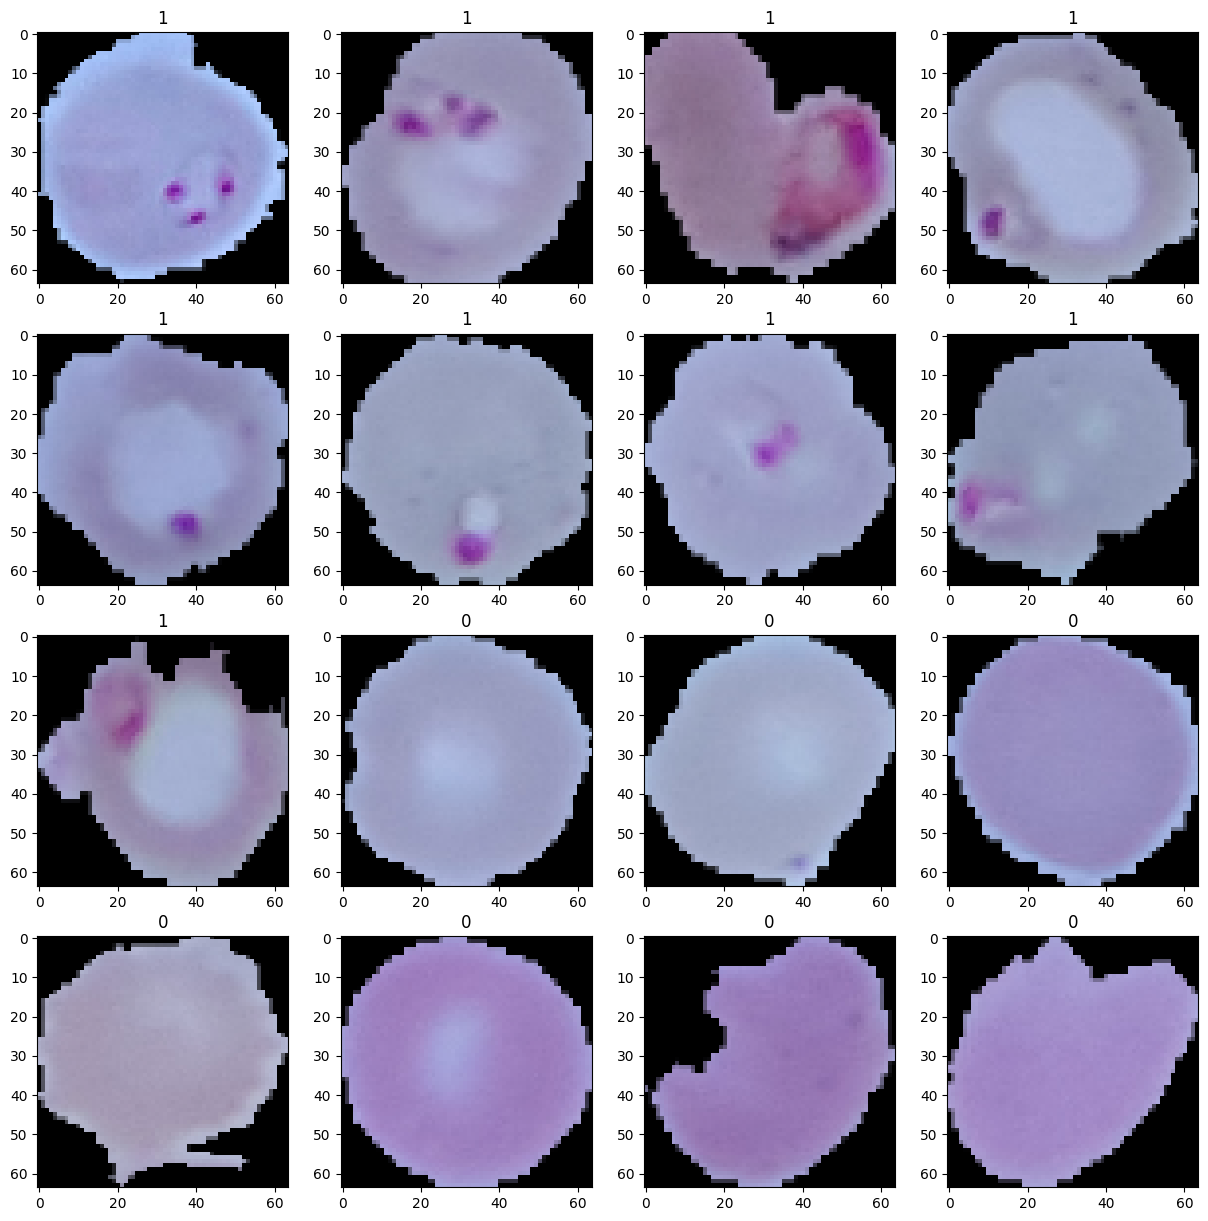

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, j in enumerate(range(0, 1000, 62)):
    ax = axs[i // 4, i % 4]
    ax.imshow(X[j])  # Plot the image
    ax.set_title(str(y[j]))  # Set the title as the label

plt.tight_layout()
plt.show()

### Modeling

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import HeNormal

In [29]:

# Define the model
model = Sequential([
    InputLayer(input_shape=(img_size, img_size, 3), name="InputLayer"),
    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer=HeNormal()),
    MaxPool2D(pool_size=2, strides=2),
    BatchNormalization(),

    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer=HeNormal()),
    MaxPool2D(pool_size=2, strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation="relu", kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(128, activation="relu", kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                      

In [33]:
model.compile(optimizer= Adam(learning_rate = 0.0001),
              loss = BinaryCrossentropy(),
              metrics = "accuracy")

In [15]:
from sklearn.model_selection import train_test_split

In [18]:
# train is 70% of the entire data set
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2)

# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5) 

In [19]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [20]:
X_train = X_train.astype('float32')
X_val  = X_val.astype('float32')
X_test  = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

In [21]:
X_train[0].shape

(64, 64, 3)

In [24]:
len(X_test)

100

In [34]:
history = model.fit(x = X_train, y=y_train, validation_data=(X_val,y_val), epochs=300, batch_size=1, verbose=1)

Epoch 1/100
800/800 [==============================] - 8s 8ms/step - loss: 0.6921 - accuracy: 0.5025 - val_loss: 0.6929 - val_accuracy: 0.5100
Epoch 2/100
800/800 [==============================] - 6s 8ms/step - loss: 0.6901 - accuracy: 0.5050 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 3/100
800/800 [==============================] - 6s 8ms/step - loss: 0.8100 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 4/100
800/800 [==============================] - 7s 9ms/step - loss: 0.6925 - accuracy: 0.4988 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 5/100
800/800 [==============================] - 8s 10ms/step - loss: 0.7749 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 6/100
800/800 [==============================] - 8s 10ms/step - loss: 0.7403 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 7/100
800/800 [==============================] - 8s 10ms/step - loss: 1.4076 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5

KeyboardInterrupt: 

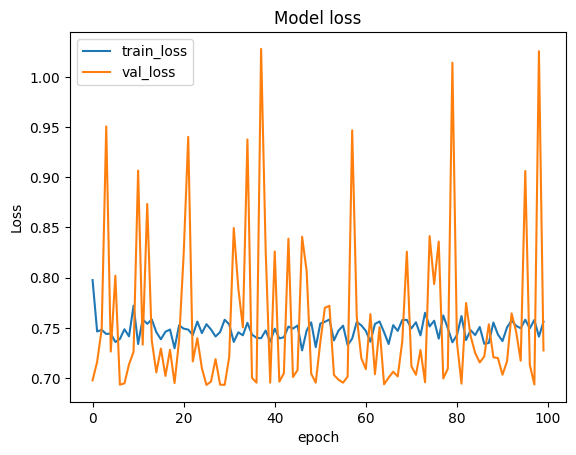

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel('Loss')
plt.xlabel("epoch")
plt.legend(['train_loss', 'val_loss'])
plt.show()

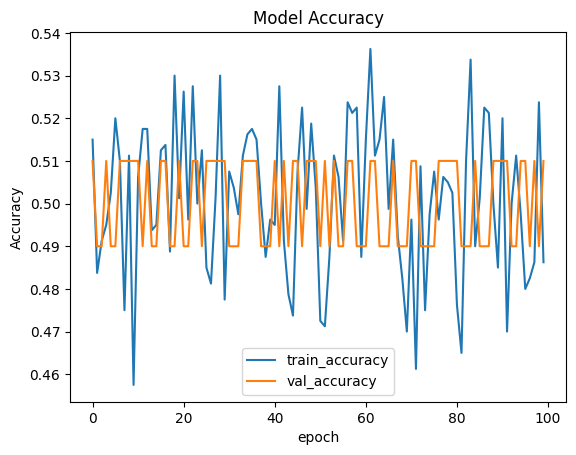

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel("epoch")
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [47]:
X_test[0].shape

(224, 224, 3)

In [50]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

5/5 [==============================] - 1s 85ms/step - loss: 0.7176 - accuracy: 0.4800
Validation Loss: 0.7176237106323242
Validation Accuracy: 0.47999998927116394


In [52]:
pred = model.predict(X_test)

5/5 [==============================] - 0s 80ms/step


In [40]:
def parasite_or_not(x):
    if(x<0.5):
        return str("Parasite")
    else:
        return str("Uninfected")

In [70]:
results = parasite_or_not(pred[40])

In [71]:
results

'Uninfected'

In [69]:
y_test[40]

1